In [41]:
from evaluate import evaluator
from datasets import load_from_disk
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

In [42]:
ds = load_from_disk('../data/efcamdat_dataset')
model = AutoModelForSequenceClassification.from_pretrained('../bin/efcamdat_nli_1').cuda()
tokenizer = AutoTokenizer.from_pretrained('../bin/efcamdat_nli_1')

In [45]:
label_names = ds['test'].features['labels'].names

id2label = {idnum: label for idnum, label in enumerate(label_names)}
label2id = {label: idnum for idnum, label in enumerate(label_names)}

model.config.id2label = id2label
model.config.label2id = label2id

# Pipeline for individual results

In [50]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0)

In [54]:
preds = pipe(ds['test']['text'], top_k=1)

## More

In [65]:
assert preds[1][0]['label'] == id2label[ds['test']['labels'][1]]



In [68]:
y_true = [id2label[lab] for lab in ds['test']['labels']]
y_pred = [pred[0]['label'] for pred in preds]

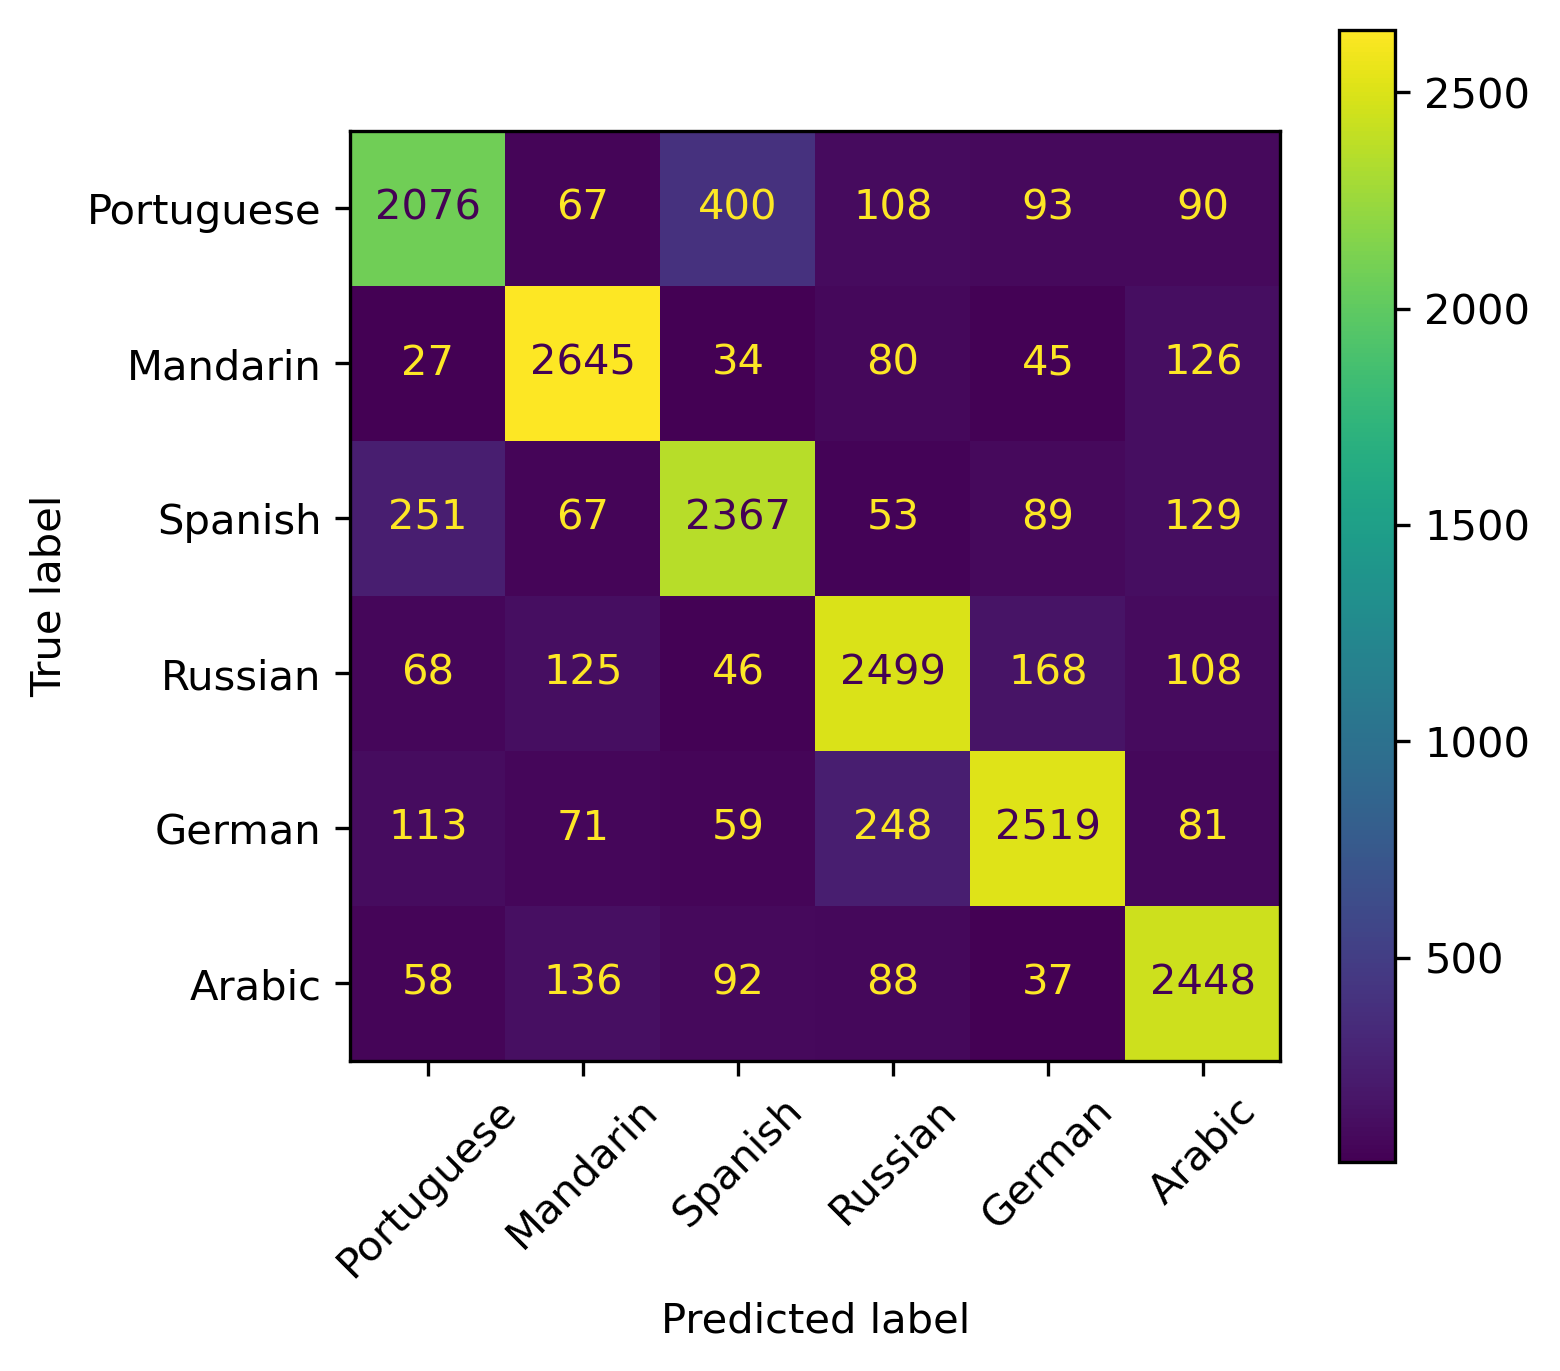

In [85]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['figure.dpi'] = 300
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=label_names)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_names).plot()

disp.ax_.set_xticklabels(label_names, rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

# Evaluator for gross results

In [37]:
task_evaluator = evaluator('text-classification')

results = task_evaluator.compute(
    model_or_pipeline=model,
    tokenizer=tokenizer,
    label_column='labels',
    data=ds['test'].select(range(100)),
    metric='accuracy',
    label_mapping=label2id,
    strategy='bootstrap',
    n_resamples=10,
    random_state=0
)

In [38]:
results

{'accuracy': {'confidence_interval': (0.7317688574347153, 0.8388931955148324),
  'standard_error': 0.036270588023294525,
  'score': 0.8},
 'total_time_in_seconds': 0.735568867996335,
 'samples_per_second': 135.9492011569177,
 'latency_in_seconds': 0.007355688679963351}